In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [ ]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 65ms/step - loss: 1.2491
Epoch 1/1
2/2 [==============================] - 0s 60ms/step - loss: 1.3318
Epoch 1/1
2/2 [==============================] - 0s 69ms/step - loss: 1.2477
Epoch 1/1
2/2 [==============================] - 0s 67ms/step - loss: 1.3330
Epoch 1/1
2/2 [==============================] - 0s 84ms/step - loss: 1.2538
Epoch 1/1
2/2 [==============================] - 0s 90ms/step - loss: 1.3332
Epoch 1/1
2/2 [==============================] - 0s 92ms/step - loss: 1.2377
Epoch 1/1
2/2 [==============================] - 0s 92ms/step - loss: 1.3378


In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
count,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,...,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,14019.000000,14019.000000
mean,53.508956,48.304978,39.143467,35.864142,33.853582,32.708766,31.009252,30.532134,29.889138,29.160472,...,-0.092756,0.074351,-0.078729,0.056245,-0.062262,0.037315,-0.053007,0.026770,0.631143,24.580783
std,25.265697,23.647203,15.790348,14.114633,13.635226,13.107436,12.420995,12.327251,12.303024,11.835478,...,0.189374,0.188631,0.178605,0.179942,0.174700,0.173623,0.170626,0.168461,0.482512,14.504488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.608988,-0.549936,-0.600307,-0.541945,-0.571735,-0.567479,-0.657158,-0.652748,0.000000,0.000000
25%,36.699715,32.942266,29.300557,26.795949,25.189006,24.263592,22.967298,22.581471,21.864301,21.577288,...,-0.231201,-0.054963,-0.208968,-0.069964,-0.190338,-0.086448,-0.176315,-0.091484,0.000000,12.000000
50%,52.504467,46.275288,40.232948,37.269062,34.792385,33.761940,32.032204,31.681557,30.886330,30.283770,...,-0.103580,0.079912,-0.086265,0.057617,-0.065221,0.037697,-0.056799,0.026436,1.000000,25.000000
75%,69.931293,61.654675,49.519983,45.619434,43.156816,41.639572,39.837561,39.272337,38.593704,37.789133,...,0.037638,0.212040,0.045471,0.187367,0.059665,0.162881,0.068575,0.148240,1.000000,37.000000
max,185.616364,166.130890,108.506081,90.964890,90.135765,97.072968,70.160568,76.352196,74.793617,80.134895,...,0.558040,0.640284,0.536997,0.585758,0.516501,0.569030,0.544415,0.522034,1.000000,49.000000


In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.2484655380249023
(14019, 1, 11025)


In [12]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, c_targets, test_size=0.20, random_state=42)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 68ms/step - loss: 1414.0142
(1, 11025)


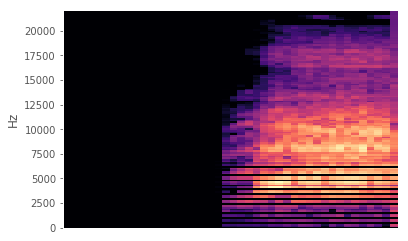

(14019, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 21ms/step - loss: 1174.7570
(1, 11025)


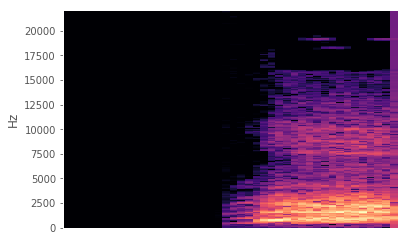

(14019, 257, 44)


In [14]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [15]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [16]:
start_time = time.time()

new_dat = []
for i in range(0, spec.shape[0]):
    new_dat.append(preprocess(mfccs[i], spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 28.524507999420166


In [17]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(14019, 45)


In [18]:
print(c_targets.shape)

(14019,)


In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, c_targets, test_size=0.20, random_state=56)

In [ ]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [ ]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5888      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

Epoch 108/200
9532/9532 [==============================] - 1s 56us/step - loss: 0.7949 - acc: 0.7743 - val_loss: 0.6299 - val_acc: 0.8396
Epoch 109/200
9532/9532 [==============================] - 1s 60us/step - loss: 0.7982 - acc: 0.7636 - val_loss: 0.6525 - val_acc: 0.8372
Epoch 110/200
9532/9532 [==============================] - 1s 58us/step - loss: 0.7831 - acc: 0.7706 - val_loss: 0.6381 - val_acc: 0.8378
Epoch 111/200
9532/9532 [==============================] - 1s 58us/step - loss: 0.7746 - acc: 0.7733 - val_loss: 0.6382 - val_acc: 0.8372
Epoch 112/200
9532/9532 [==============================] - 1s 54us/step - loss: 0.7711 - acc: 0.7743 - val_loss: 0.6454 - val_acc: 0.8348
Epoch 113/200
9532/9532 [==============================] - 1s 56us/step - loss: 0.7649 - acc: 0.7779 - val_loss: 0.6348 - val_acc: 0.8431
Epoch 114/200
9532/9532 [==============================] - 1s 55us/step - loss: 0.7673 - acc: 0.7783 - val_loss: 0.6219 - val_acc: 0.8455
Epoch 115/200
9532/9532 [=========

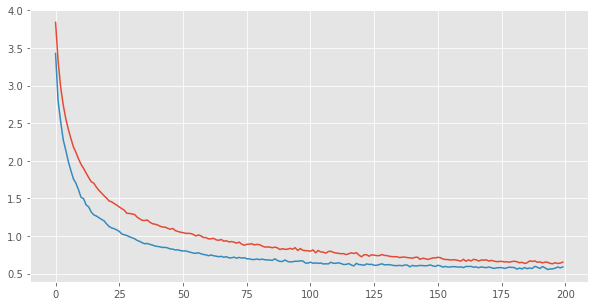

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

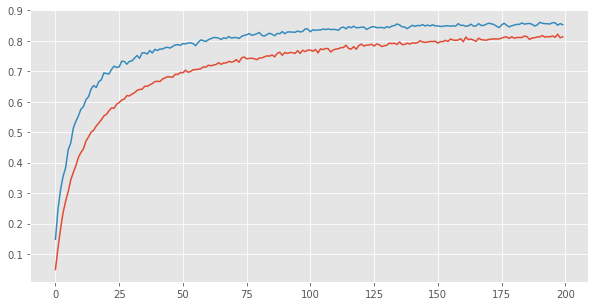

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.8577032810271041
Confusion matrix, without normalization
[[35  0  0 ...  0  6  0]
 [ 0 28  0 ...  0  1  1]
 [ 0  0 60 ...  0  0  0]
 ...
 [ 0  0  0 ... 58  0  0]
 [ 2  0  0 ...  0 44  0]
 [ 0  0  0 ...  0  0 46]]


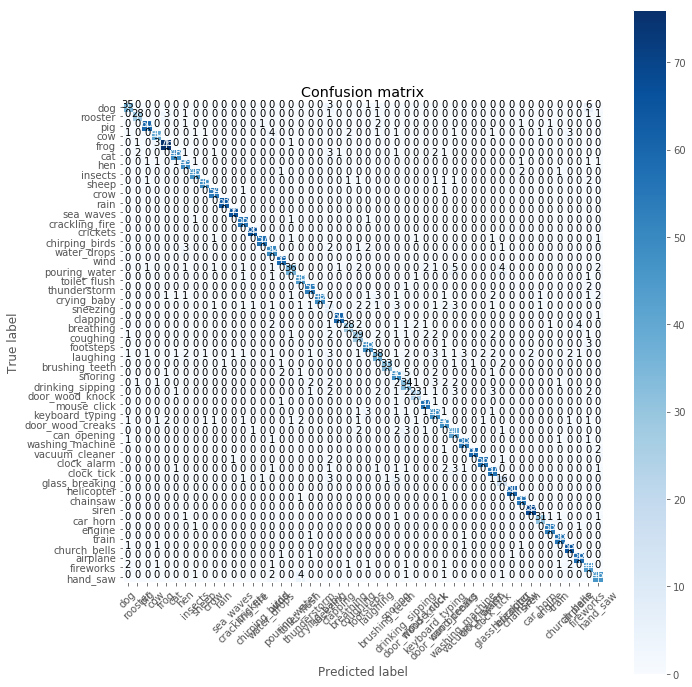

In [ ]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [ ]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 1.9986343383789062
	Processing Time: 1.697115421295166
	Processing Time: 1.7504866123199463
	Processing Time: 1.6569900512695312


In [ ]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [ ]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [ ]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 116ms/step - loss: 1440.5383
(1, 11025)


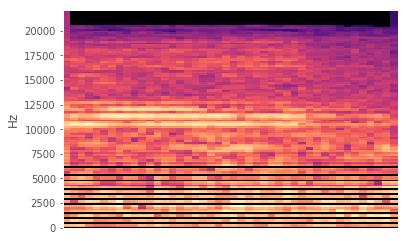

(56774, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_2 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 75ms/step - loss: 1150.4644
(1, 11025)


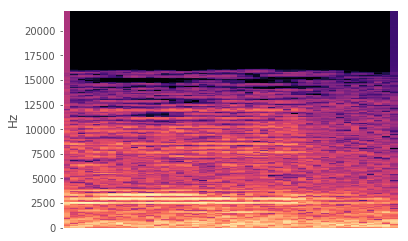

(56774, 257, 44)


In [ ]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [ ]:
start_time = time.time()

new_dat = []
for i in range(0, spec.shape[0]):
    new_dat.append(preprocess(mfccs[i], spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 114.89286971092224


In [ ]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(56774, 45)


In [ ]:
print(yy.shape)

(56774,)


In [ ]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(yy, pred))
cm = metrics.confusion_matrix(yy, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

0.17242047416070735
Confusion matrix, without normalization
[[367  26   0 ...   1  91  18]
 [ 38 218   0 ...   0  30   8]
 [  4   0 154 ...  18  13  41]
 ...
 [  0   0  38 ... 160  83   5]
 [ 61   1   7 ...  14 269   2]
 [  0   0  19 ...   3   3  70]]
